In [5]:
import matplotlib.pyplot as plt
import random

from matplotlib.colors import ListedColormap
from sklearn import datasets

import numpy as np

from sklearn import model_selection

In [6]:

X = np.array([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1],
              [1, 1, 2, 5, 3, 0, 5, 10, 1, 2],
              [500, 700, 750, 600, 1450, 800, 1500, 2000, 450, 1000],
              [1, 1, 2, 1, 2, 1, 3, 3, 1, 2]], dtype = np.float64)
y = np.array([0, 0, 1, 0, 1, 0, 1, 0, 1, 1], dtype = np.float64)

In [7]:

def calc_gini(x, y, t):
    qty_all = len(y)
    qty_left = len(y[x < t])
    qty_right = qty_all - qty_left

    # Индекс Джини не будет равен бесконечности в таком случае,
    # но и считать его особо смысла нет, т.к. получается только одна ветвь
    if qty_left == 0 or qty_right == 0:
        return np.inf

    qty0_left = ((y[x < t]) == 0).sum()
    qty0_right = ((y[x >= t]) == 0).sum()

    p0_left = qty0_left / qty_left
    p1_left = 1 - p0_left

    p0_right = qty0_right / qty_right
    p1_right = 1 - p0_right

    # Нормировочный коэффициент для левого листа
    left_coef = qty_left / qty_all

    # Индекс Джини для левого листа
    h_left = p0_left * (1 - p0_left) + p1_left * (1 - p1_left)
    # Индекс Джини для правого листа
    h_right = p0_right * (1 - p0_right) + p1_right * (1 - p1_right)

    res = left_coef * h_left + (1 - left_coef) * h_right
    return res

In [8]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity, classes

In [9]:
def quality_0(left_labels, right_labels):

    # доля выбоки, ушедшая в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0])
    gini_left, _ = gini(left_labels)
    gini_right, _ = gini(right_labels)
    
    return p * gini_left + (1 - p) * gini_right

In [10]:
classification_data, classification_labels = datasets.make_classification(n_features = 2, n_informative = 2, 
                                                      n_classes = 4, n_redundant=0, 
                                                      n_clusters_per_class=1, random_state=5)

In [11]:
train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

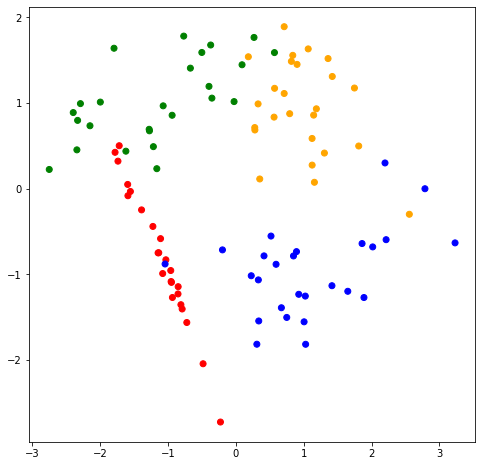

In [12]:
colors = ListedColormap(['red', 'blue', 'green', 'orange'])
light_colors = ListedColormap(['lightcoral', 'lightblue'])

plt.figure(figsize=(8,8))
plt.scatter(list(map(lambda x: x[0], classification_data)), list(map(lambda x: x[1], classification_data)), 
              c=classification_labels, cmap=colors)
plt.show()

In [13]:
# Реализуем класс узла

class Node:
    
    def __init__(self, index, t, true_branch, false_branch):
        self.index = index  # индекс признака, по которому ведется сравнение с порогом в этом узле
        self.t = t  # значение порога
        self.true_branch = true_branch  # поддерево, удовлетворяющее условию в узле
        self.false_branch = false_branch  # поддерево, не удовлетворяющее условию в узле

In [14]:
# И класс терминального узла (листа)

class Leaf:
    
    def __init__(self, data, labels):
        self.data = data
        self.labels = labels  # y_true
        self.prediction = self.predict()  # y_pred
        
    def predict(self):
        # подсчет количества объектов разных классов
        classes = {}  # сформируем словарь "класс: количество объектов"
        for label in self.labels:
            if label not in classes:
                classes[label] = 0
            classes[label] += 1
        #  найдем класс, количество объектов которого будет максимальным в этом листе и вернем его    
        prediction = max(classes, key=classes.get)
        return prediction

In [15]:
# Расчет критерия Джини

def gini(labels):
    #  подсчет количества объектов разных классов
    classes = {}
    for label in labels:
        if label not in classes:
            classes[label] = 0
        classes[label] += 1
    
    #  расчет критерия
    impurity = 1     # "impurity" - "нечистота", степень неопределенности
    for label in classes:
        p = classes[label] / len(labels)
        impurity -= p ** 2
        
    return impurity

In [16]:
# Расчет качества

def quality(left_labels, right_labels, current_gini):

    # доля выборки, ушедшей в левое поддерево
    p = float(left_labels.shape[0]) / (left_labels.shape[0] + right_labels.shape[0]) # для правого (1-p)
    
    return current_gini - p * gini(left_labels) - (1 - p) * gini(right_labels)

In [17]:
# Разбиение датасета в узле

def split(data, labels, index, t):
    
    left = np.where(data[:, index] <= t)
    right = np.where(data[:, index] > t)
        
    true_data = data[left]
    false_data = data[right]
    true_labels = labels[left]
    false_labels = labels[right]
        
    return true_data, false_data, true_labels, false_labels

In [18]:
# Нахождение наилучшего разбиения

def find_best_split(data, labels):
    
    #  обозначим минимальное количество объектов в узле
    min_leaf = 5

    current_gini = gini(labels)

    best_quality = 0
    best_t = None
    best_index = None
    
    n_features = data.shape[1]
    
    for index in range(n_features):
        t_values = [row[index] for row in data]
        
        for t in t_values:
            true_data, false_data, true_labels, false_labels = split(data, labels, index, t)
            #  пропускаем разбиения, в которых в узле остается менее 5 объектов
            if len(true_data) < min_leaf or len(false_data) < min_leaf:
                continue
            
            current_quality = quality(true_labels, false_labels, current_gini)
            
            #  выбираем порог, на котором получается максимальный прирост качества
            if current_quality > best_quality:
                best_quality, best_t, best_index = current_quality, t, index

    return best_quality, best_t, best_index

In [19]:
# Построение дерева с помощью рекурсивной функции

def build_tree(data, labels):

    quality, t, index = find_best_split(data, labels)
#     print(quality, t, index)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0:
#         print('leaf')
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree(true_data, true_labels)
    false_branch = build_tree(false_data, false_labels)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [20]:
# Проход объекта по дереву для его классификации

def classify_object(obj, node):

    #  Останавливаем рекурсию, если достигли листа
    if isinstance(node, Leaf):
        answer = node.prediction
        return answer

    if obj[node.index] <= node.t:
        return classify_object(obj, node.true_branch)
    else:
        return classify_object(obj, node.false_branch)

In [21]:
# Предсказание деревом для всего датасета

def predict(data, tree):
    
    classes = []
    for obj in data:
        prediction = classify_object(obj, tree)
        classes.append(prediction)
    return classes

In [22]:
# Разобьем выборку на обучающую и тестовую

from sklearn import model_selection

train_data, test_data, train_labels, test_labels = model_selection.train_test_split(classification_data, 
                                                                                     classification_labels, 
                                                                                     test_size = 0.3,
                                                                                     random_state = 1)

In [23]:
# Построим дерево по обучающей выборке
my_tree = build_tree(train_data, train_labels)

In [24]:
# Напечатаем ход нашего дерева
def print_tree(node, spacing=""):

    # Если лист, то выводим его прогноз
    if isinstance(node, Leaf):
        print(spacing + "Прогноз:", node.prediction)
        return

    # Выведем значение индекса и порога на этом узле
    print(spacing + 'Индекс', str(node.index))
    print(spacing + 'Порог', str(node.t))

    # Рекурсионный вызов функции на положительном поддереве
    print (spacing + '--> True:')
    print_tree(node.true_branch, spacing + "  ")

    # Рекурсионный вызов функции на отрицательном поддереве
    print (spacing + '--> False:')
    print_tree(node.false_branch, spacing + "  ")
    
print_tree(my_tree)

Индекс 0
Порог -0.22559299118317355
--> True:
  Индекс 1
  Порог 0.04851372335919213
  --> True:
    Прогноз: 0
  --> False:
    Индекс 1
    Порог 0.5005471840301747
    --> True:
      Прогноз: 2
    --> False:
      Прогноз: 2
--> False:
  Индекс 1
  Порог -0.5541425015178428
  --> True:
    Прогноз: 1
  --> False:
    Индекс 1
    Порог 1.538703385144479
    --> True:
      Индекс 0
      Порог 1.1874849059327177
      --> True:
        Прогноз: 3
      --> False:
        Прогноз: 3
    --> False:
      Прогноз: 3


In [25]:
# Получим ответы для обучающей выборки 
train_answers = predict(train_data, my_tree)

In [26]:
# И получим ответы для тестовой выборки
answers = predict(test_data, my_tree)

In [27]:
# Введем функцию подсчета точности как доли правильных ответов
def accuracy_metric(actual, predicted):
    correct = 0
    for i in range(len(actual)):
        if actual[i] == predicted[i]:
            correct += 1
    return correct / float(len(actual)) * 100.0

In [28]:
# Точность на обучающей выборке
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

92.85714285714286

In [29]:
# Точность на тестовой выборке
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

83.33333333333334

Text(0.5, 1.0, 'Test accuracy=83.33')

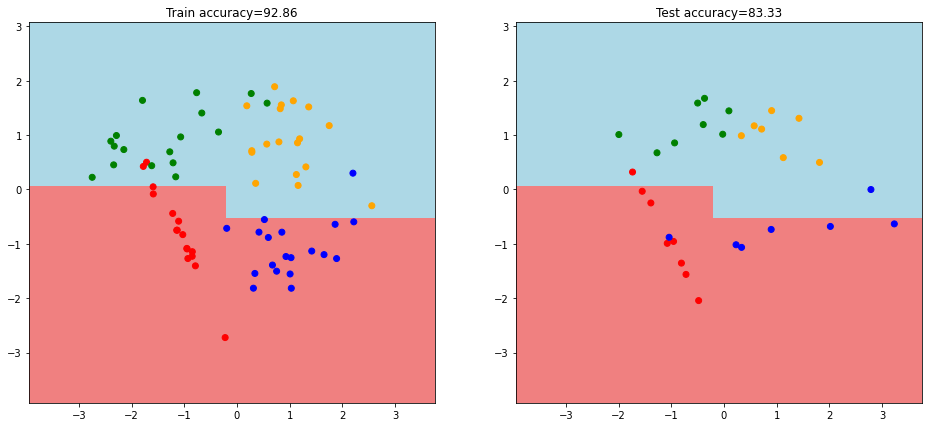

In [30]:
# Визуализируем дерево на графике

def get_meshgrid(data, step=.05, border=1.2):
    x_min, x_max = data[:, 0].min() - border, data[:, 0].max() + border
    y_min, y_max = data[:, 1].min() - border, data[:, 1].max() + border
    return np.meshgrid(np.arange(x_min, x_max, step), np.arange(y_min, y_max, step))

plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

# Ограничение на количество листьев

In [31]:
def build_tree_leaf_lim_tr(data, labels, leaf_lim = 100, leaves = 0, br = 0):
    
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or (leaf_lim - leaves - br) < 2:
        leaves += 1
        return Leaf(data, labels), leaves, br

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    br += 1
    true_branch, leaves, br = build_tree_leaf_lim_tr(true_data, true_labels, leaf_lim, leaves, br)
    br -= 1
    false_branch, leaves, br = build_tree_leaf_lim_tr(false_data, false_labels, leaf_lim, leaves, br)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch), leaves, br

In [32]:
my_tree_ll_tr, leaves, br = build_tree_leaf_lim_tr(train_data, train_labels, 4)

In [33]:
print_tree(my_tree_ll_tr)

Индекс 0
Порог -0.22559299118317355
--> True:
  Индекс 1
  Порог 0.04851372335919213
  --> True:
    Прогноз: 0
  --> False:
    Индекс 1
    Порог 0.5005471840301747
    --> True:
      Прогноз: 2
    --> False:
      Прогноз: 2
--> False:
  Прогноз: 1


In [34]:
print("Листьев: {}".format(leaves))

Листьев: 4


In [35]:
train_answers = predict(train_data, my_tree_ll_tr)
answers = predict(test_data, my_tree_ll_tr)
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

68.57142857142857

In [36]:
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

63.33333333333333

Text(0.5, 1.0, 'Test accuracy=63.33')

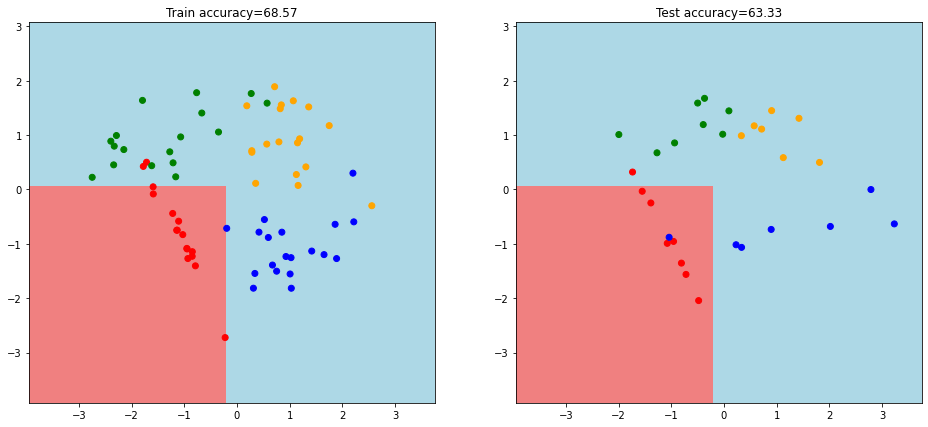

In [37]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_ll_tr)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')

# Ограничение на глубину

In [38]:
def build_tree_depth_lim(data, labels, depth_lim = 20, depth = 0):
    
    quality, t, index = find_best_split(data, labels)

    #  Базовый случай - прекращаем рекурсию, когда нет прироста в качества
    if quality == 0 or depth >= depth_lim:
        #print(depth)
        return Leaf(data, labels)

    true_data, false_data, true_labels, false_labels = split(data, labels, index, t)

    # Рекурсивно строим два поддерева
    true_branch = build_tree_depth_lim(true_data, true_labels, depth_lim, depth + 1)
    false_branch = build_tree_depth_lim(false_data, false_labels, depth_lim, depth + 1)

    # Возвращаем класс узла со всеми поддеревьями, то есть целого дерева
    return Node(index, t, true_branch, false_branch)

In [39]:
my_tree_dl = build_tree_depth_lim(train_data, train_labels, 1)

In [40]:
print_tree(my_tree_dl)

Индекс 0
Порог -0.22559299118317355
--> True:
  Прогноз: 0
--> False:
  Прогноз: 1


In [41]:
train_answers = predict(train_data, my_tree_dl)
answers = predict(test_data, my_tree_dl)
train_accuracy = accuracy_metric(train_labels, train_answers)
train_accuracy

50.0

In [42]:
test_accuracy = accuracy_metric(test_labels, answers)
test_accuracy

46.666666666666664

Text(0.5, 1.0, 'Test accuracy=46.67')

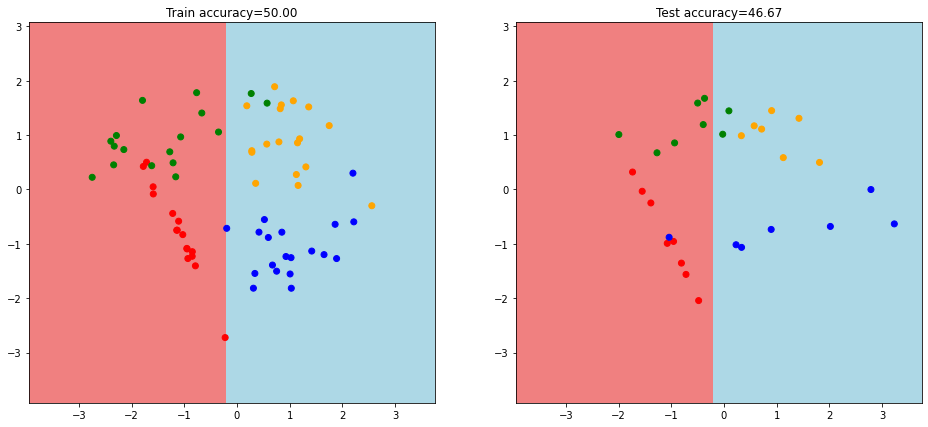

In [43]:
plt.figure(figsize = (16, 7))

# график обучающей выборки
plt.subplot(1,2,1)
xx, yy = get_meshgrid(train_data)
mesh_predictions = np.array(predict(np.c_[xx.ravel(), yy.ravel()], my_tree_dl)).reshape(xx.shape)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(train_data[:, 0], train_data[:, 1], c = train_labels, cmap = colors)
plt.title(f'Train accuracy={train_accuracy:.2f}')

# график тестовой выборки
plt.subplot(1,2,2)
plt.pcolormesh(xx, yy, mesh_predictions, cmap = light_colors)
plt.scatter(test_data[:, 0], test_data[:, 1], c = test_labels, cmap = colors)
plt.title(f'Test accuracy={test_accuracy:.2f}')